# Virginia Redistricting Plan Metrics

### Road map of metric calculation:

* [Step 1](#1): Setting up the initial districting plan
    * [Step 1.1](#1.1): Generating partition graph
    * [Step 1.2](#1.2): Setting up election data
    * [Step 1.3](#1.3): Configuring updater
    * [Step 1.4](#1.4): Instantiating partition
* [Step 2](#2): Comuting metrics
    * [Step 2.1](#2.1): Computing Congressional district
    * [Step 2.2](#2.2): Computing compactness score
    * [Step 2.3](#2.3): Computing total votes by party
    * [Step 2.4](#2.4): Computing wasted votes by district
    * [Step 2.5](#2.5): Computing voting percentage by district
    * [Step 2.6](#2.6): Computing seats won by party
    * [Step 2.7](#2.7): Computing efficiency gap score
    * [Step 2.8](#2.8): Computing mean-median score
    * [Step 2.9](#2.9): Computing partisan bias score
    * [Step 2.10](#2.10): Computing partisan gini index
    
### Resource:

* Data
    * [Virginia Election Shapefile](https://github.com/mggg-states/VA-shapefiles)
* Software
    * [Getting started with GerryChain](https://gerrychain.readthedocs.io/en/latest/user/quickstart.html)
* Metric
    * [Partisan symmetry, efficiency gap and algorithmic sampling](https://arxiv.org/pdf/1801.02064.pdf)
    * [Partisan gerrymandering and efficiency gap](https://arxiv.org/pdf/1705.10812.pdf)
    * [Virginia Gerrymandering analysis](https://mggg.org/VA-report.pdf)

## Step 0: Imports

In [1]:
# Common packages
import pandas as pd
import numpy as np
import os

# Visualization packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# GerryChain related packages
import networkx as nx
import maup
import geopandas
from functools import partial
import gerrychain
from gerrychain import (
    GeographicPartition, 
    Partition, 
    Graph, 
    MarkovChain,
    proposals, 
    updaters, 
    constraints, 
    accept, 
    Election
)
from gerrychain.constraints import (
    single_flip_contiguous, 
    no_more_discontiguous,
    Validator
)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept
import gerrychain.metrics as gm
import gerrychain.metrics.partisan as pm

# Aesthetic setting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Reproducibility setting
random_state = 2020
np.random.seed(random_state)

<a id='1'></a>
## Step 1: Setting up the initial districting plan

<a id='1.1'></a>
### 1.1 Generating a graph to be partitioned

In [2]:
# Crearte path to .shp file
DATA_PATH = os.path.join('.', 'va.shp')

In [3]:
# Loading the .shp file into a graph
graph = Graph.from_file(DATA_PATH)

<a id='1.2'></a>
### 1.2 Setting up election data

In [4]:
# Configure 2016 Presidential Election objects representing 
elections = [
    # 2016 Presidential Election
    Election("PRES16", {"Democratic": "G16DPRS", "Republican": "G16RPRS"})
]

# Create eletion updater
election_updaters = {election.name: election for election in elections}

<a id='1.3'></a>
### 1.3 Configuring  updaters

In [5]:
# Configure our updaters 
updaters = {
    "cut_edges": cut_edges,
    # Total population in VA
    "population": Tally("TOTPOP", alias="population"),
}

# Update with elections updater
updaters.update(election_updaters)

<a id='1.4'></a>
### 1.4 Instantiating  partition

In [6]:
# Instantiate the initial state of Markov chain, using 2012 enacted congressional district ID.
partition_12 = GeographicPartition(
    graph, 
    assignment="CD_12", 
    updaters=updaters
)
# Instantiate the initial state of Markov chain, using 2016 enacted congressional district ID.
partition_16 = GeographicPartition(
    graph, 
    assignment="CD_16", 
    updaters=updaters
)

<a id='2'></a>
## Step 2: Computing metrics 

<a id='2.1'></a>
### 2.1 Congressional district map

In [7]:
def plot_partition(partition, title, figsize=(13,6)):
    """
    Plot districting plan.
    """
    partition.plot(figsize=figsize, cmap="tab20", legend=True)
    plt.axis('off')
    plt.title(title, fontsize=22)
    plt.show()

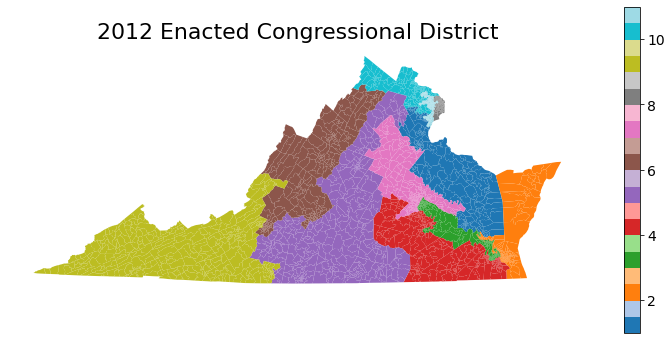

In [8]:
# Plotting 2012 districting plan
title = "2012 Enacted Congressional District"
plot_partition(partition_12, title)

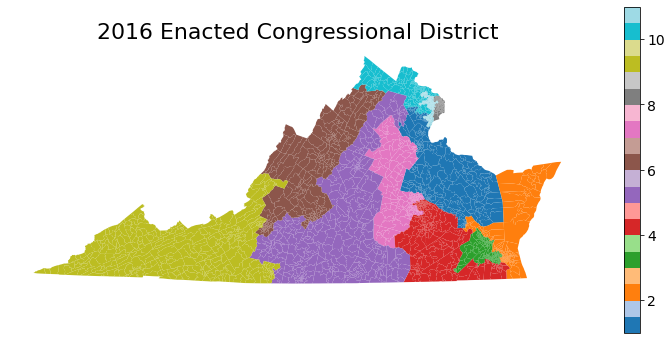

In [9]:
# Plotting 2016 districting plan
title = "2016 Enacted Congressional District"
plot_partition(partition_16, title)

<a id='2.2'></a>
### 2.2 Compactness score

A district's `Polsby-Popper score` falls with the range of `[0,1]` and a score closer to 1 indicates a more compact district.

In [10]:
def plot_barchar(data, title, xlab, ylab, ylim=None, ytick=False, legend=True, figsize=(12,8)):
    if ylim:
        ax = data.plot(kind='bar', rot=0, figsize=figsize, ylim=ylim)
    else:
        ax = data.plot(kind='bar', rot=0, figsize=figsize)
    plt.title(title, fontsize=22)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if ytick:
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
    plt.grid(axis='y')
    if legend:
        plt.legend(fontsize=10)
    else:
        ax.get_legend().remove()
    plt.show()

In [11]:
# Compute Polsby-Popper compactness scores for each district in the 2012 partition
compact_scores_12 = gm.polsby_popper(partition_12)

# Compute Polsby-Popper compactness scores for each district in the 2016 partition
compact_scores_16 = gm.polsby_popper(partition_16)

# Create a dataframe to store 2012 and 2016 compact scores
dist_index= range(1,12)
df_compact = pd.DataFrame(
    data={
        2012: list(compact_scores_12.values()),
        2016: list(compact_scores_16.values())
    },
    index=dist_index
).round(decimals=2)

# Display the dataframe
df_compact

,2012,2016
1,0.17,0.23
2,0.20,0.22
3,0.08,0.22
4,0.19,0.20
5,0.15,0.21
6,0.16,0.15
7,0.13,0.16
8,0.25,0.25
9,0.18,0.18
10,0.12,0.12


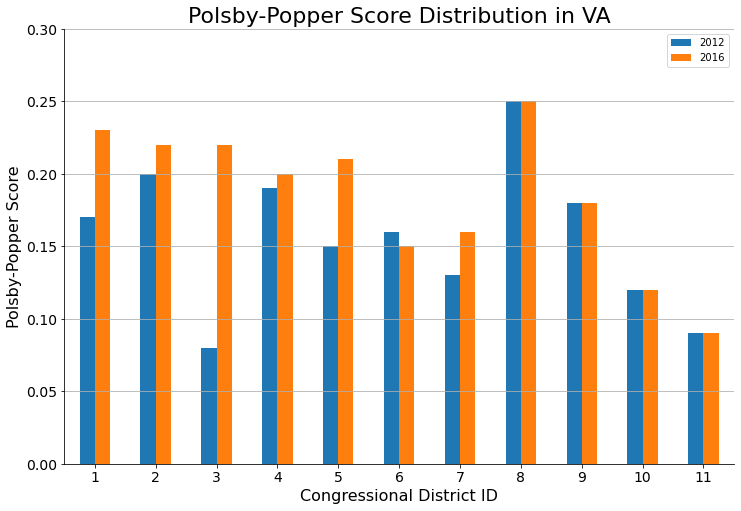

In [12]:
ylim = (0.0,0.3)
title = "Polsby-Popper Score Distribution in VA"
xlab = 'Congressional District ID'
ylab = 'Polsby-Popper Score'
plot_barchar(df_compact, title, xlab, ylab, ylim)

<a id='2.3'></a>
### 2.3 Vote

The total number of votes that `party` received.

In [13]:
def compute_stats(election, parties, compute, stat):
    """
    Compute statistics in the result of an election.
    """
    for party in parties:
        print("Party: {:15}".format(party),  
              "{}: {:,}".format(stat, compute(party)))

In [14]:
# 2016 Presidential Election using 2012 plan
pres16 = 'PRES16'
pres16_12 = partition_12[pres16]

# 2016 Presidential Election using 2016 plan
pres16_16 = partition_16[pres16]

# U.S. parties
parties = pres16_12.election.parties[:2]

In [15]:
# Calculate the seats won by each party using 2012 & 2016 plans
votes = {
    "2012": [pres16_12.count('Democratic'), pres16_16.count('Republican')], 
    "2016": [pres16_12.count('Democratic'), pres16_16.count('Republican')]
}

# Create a dataframe to store the seats won data
df_votes = pd.DataFrame(data=votes, index=parties)
df_votes

,2012,2016
Democratic,1978980,1978980
Republican,1768781,1768781


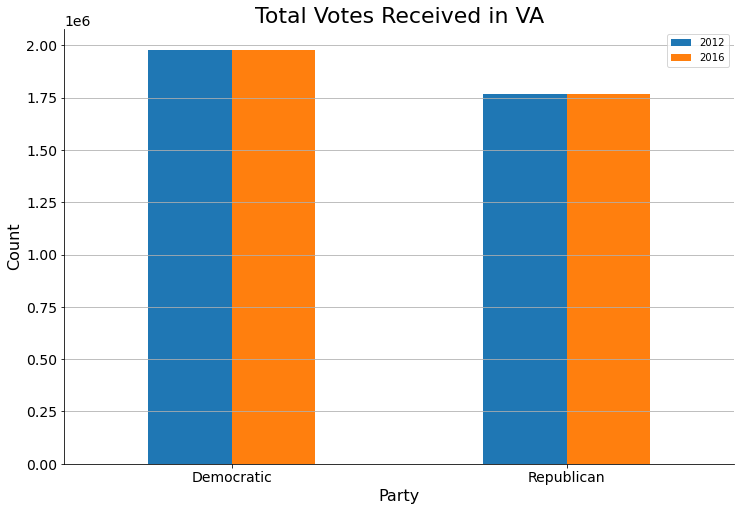

In [16]:
ylim = None
title = "Total Votes Received in VA"
xlab = 'Party'
ylab = 'Count'
plot_barchar(df_votes, title, xlab, ylab, ylim)

<a id='2.4'></a>
### 2.4 Wasted votes

Computes the wasted votes for each party in the given race. :party1_votes: the number of votes party1 received in the race :party2_votes: the number of votes party2 received in the race

In [17]:
# Wasted votes in total using 2012 plan
d, r = \
    gm.wasted_votes(pres16_12.count('Democratic'), pres16_12.count('Republican'))
print(f"Democratic: {d:,} Republican: {r:,}")

# Wasted votes in total using 2016 plan
d, r = \
    gm.wasted_votes(pres16_16.count('Democratic'), pres16_16.count('Republican'))
print(f"Democratic: {d:,} Republican: {r:,}")

Democratic: 105,099.5 Republican: 1,768,781
Democratic: 105,099.5 Republican: 1,768,781


In [18]:
wasted_votes = {
    "Democratic 2012": [], 
    "Republican 2012": [],
    "Democratic 2016": [], 
    "Republican 2016": []
}

# Calculate wasted votes by district using 2012 plan
for d, r in zip(pres16_12.votes('Democratic'), pres16_12.votes('Republican')):
    wd, wr = gm.wasted_votes(d, r)
    wasted_votes['Democratic 2012'].append(wd)
    wasted_votes['Republican 2012'].append(wr)

# Calculate wasted votes by district using 2016 plan
for d, r in zip(pres16_16.votes('Democratic'), pres16_16.votes('Republican')):
    wd, wr = gm.wasted_votes(d, r)
    wasted_votes['Democratic 2016'].append(wd)
    wasted_votes['Republican 2016'].append(wr)

In [19]:
# Create a dataframe to store the 2012 and 2016 ver. wasted votes
df_wasted_votes = pd.DataFrame(wasted_votes, index=dist_index)
df_wasted_votes = df_wasted_votes.reindex(columns=(sorted(wasted_votes.keys())))
df_wasted_votes = df_wasted_votes.astype(int)
df_wasted_votes

,Democratic 2012,Democratic 2016,Republican 2012,Republican 2016
1,165747,162901,15089,24952
2,132,147364,148818,5307
3,89861,51169,67811,102212
4,164013,172402,8634,12868
5,153029,38931,20907,134681
6,120447,153029,42786,20907
7,173387,120447,19296,42786
8,97632,97632,77091,77091
9,86635,86635,65521,65521
10,18663,18663,168230,168230


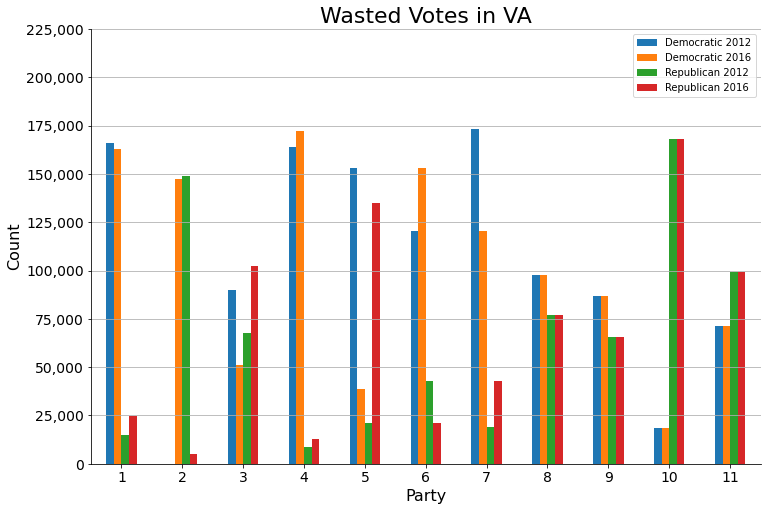

In [20]:
ylim = (0, 225_000)
ytick = True
title = "Wasted Votes in VA"
ylab = 'Count'
plot_barchar(df_wasted_votes, title, xlab, ylab, ylim, ytick)

<a id='2.5'></a>
### 2.5 Percents by district

The percentage of the vote that party received in each district of the partition.

In [21]:
# Total percentages of vote received by each party using 2012 plan
compute_stats(pres16_12, parties, pres16_12.percent, "Percentage of Total Votes 2012")

# Total percentages of vote received by each party using 2016 plan
compute_stats(pres16_16, parties, pres16_16.percent, "Percentage of Total Votes 2016")

Party: Democratic      Percentage of Total Votes 2012: 0.5280432770392776
Party: Republican      Percentage of Total Votes 2012: 0.47195672296072244
Party: Democratic      Percentage of Total Votes 2016: 0.5280432770392776
Party: Republican      Percentage of Total Votes 2016: 0.47195672296072244


In [22]:
df_percentages = pd.DataFrame(
    data={
    'Democratic 2012': pres16_12.percents(parties[0]),
    'Democratic 2016': pres16_16.percents(parties[0]),
    'Republican 2012': pres16_12.percents(parties[1]),
    'Republican 2016': pres16_16.percents(parties[1])
    },
    index=dist_index
)
df_percentages = df_percentages.mul(100).astype(int)
df_percentages

,Democratic 2012,Democratic 2016,Republican 2012,Republican 2016
1,45,43,54,56
2,50,48,49,51
3,78,66,21,33
4,47,46,52,53
5,43,61,56,38
6,36,43,63,56
7,44,36,55,63
8,77,77,22,22
9,28,28,71,71
10,54,54,45,45


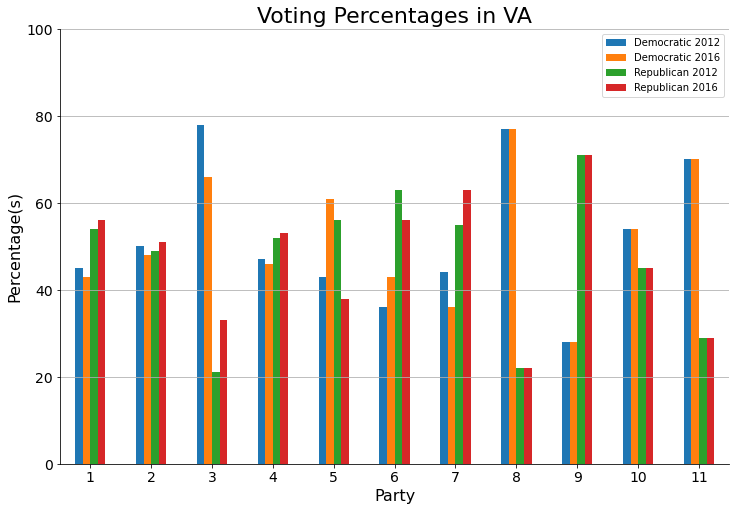

In [23]:
ylim = (0,100)
ytick = False
title = "Voting Percentages in VA"
ylab = 'Percentage(s)'
plot_barchar(df_percentages, title, xlab, ylab, ylim, ytick)

<a id='2.6'></a>
### 2. 6 Seats

The number of seats won by a party in the election.

In [24]:
# Seats won using 2012 plan
compute_stats(pres16_12, parties, pres16_12.seats, 'Seats won 2012')

# Seats won using 2016 plan
compute_stats(pres16_16, parties, pres16_16.seats, 'Seats won 2016')

Party: Democratic      Seats won 2012: 5
Party: Republican      Seats won 2012: 6
Party: Democratic      Seats won 2016: 5
Party: Republican      Seats won 2016: 6


In [25]:
# Calculate the seats won by each party using 2012 & 2016 plans
seats = {
    "2012": [pres16_12.seats('Democratic'), pres16_16.seats('Republican')], 
    "2016": [pres16_12.seats('Democratic'), pres16_16.seats('Republican')]
}

# Create a dataframe to store the seats won data
df_seats = pd.DataFrame(data=seats, index=parties)
df_seats

,2012,2016
Democratic,5,5
Republican,6,6


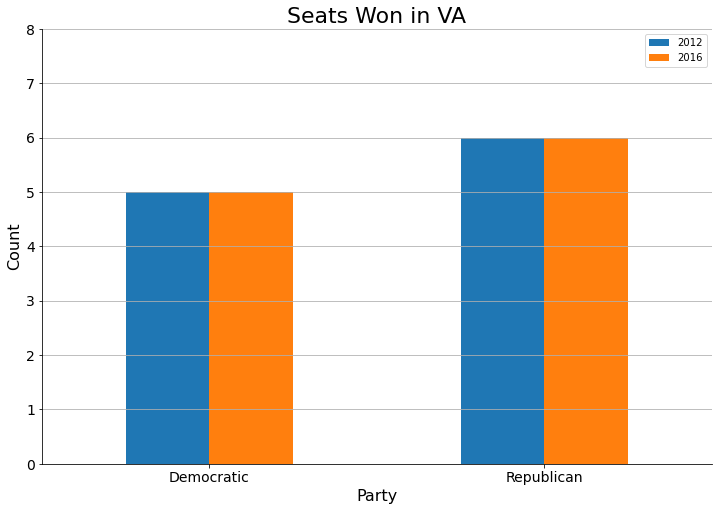

In [26]:
ylim = (0,8)
title = "Seats Won in VA"
xlab = 'Party'
ylab = 'Count'
plot_barchar(df_seats, title, xlab, ylab, ylim)

<a id='2.7'></a>
### 2.7 Efficiency gap

Computes the efficiency gap for this ElectionResults object. `A positive value` indicates `an advantage` for `the first party` listed in the Election’s parties_to_columns dictionary.

In [27]:
def compute_metric(metric, plan2012, plan2016):
    """
    Computer metric using 2012 and 2016 plan.
    """
    score = {
        metric: [plan2012(), plan2016()], 
    }

    score = pd.DataFrame(data=score, index=[2012, 2016]).round(2)
    return score

In [28]:
metric = 'Efficiency Gap'
plan2012 = pres16_12.efficiency_gap
plan2016 = pres16_16.efficiency_gap
df_effi = compute_metric(metric, plan2012, plan2016)
df_effi

,Efficiency Gap
2012,-0.11
2016,-0.10


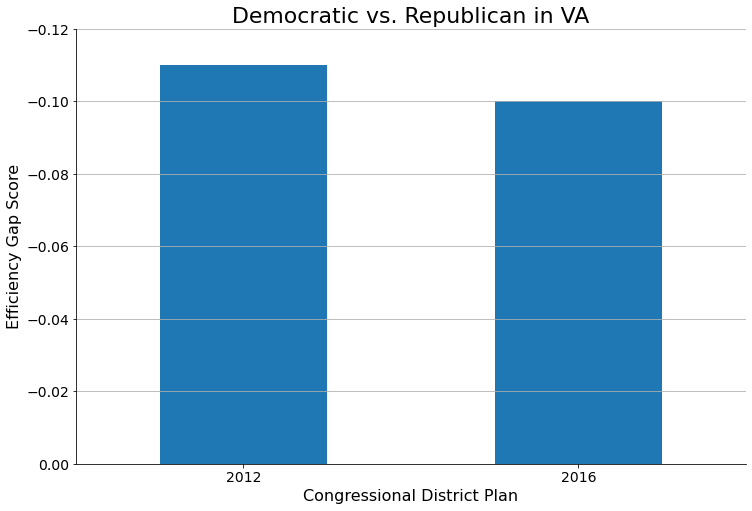

In [29]:
ylim = (0,-0.12)
title = "Democratic vs. Republican in VA"
xlab = 'Congressional District Plan'
ylab = 'Efficiency Gap Score'
legend = False
plot_barchar(df_effi, title, xlab, ylab, ylim, legend=legend)

<a id='2.8'></a>
### 2.8 Mean-Median

Computes the Mean-Median score for the given ElectionResults. `A positive value` indicates `an advantage` for `the first party` listed in the Election’s parties_to_columns dictionary.

In [30]:
metric = 'Mean Median'
plan2012 = pres16_12.mean_median
plan2016 = pres16_16.mean_median
df_mm = compute_metric(metric, plan2012, plan2016)
df_mm

,Mean Median
2012,-0.05
2016,-0.04


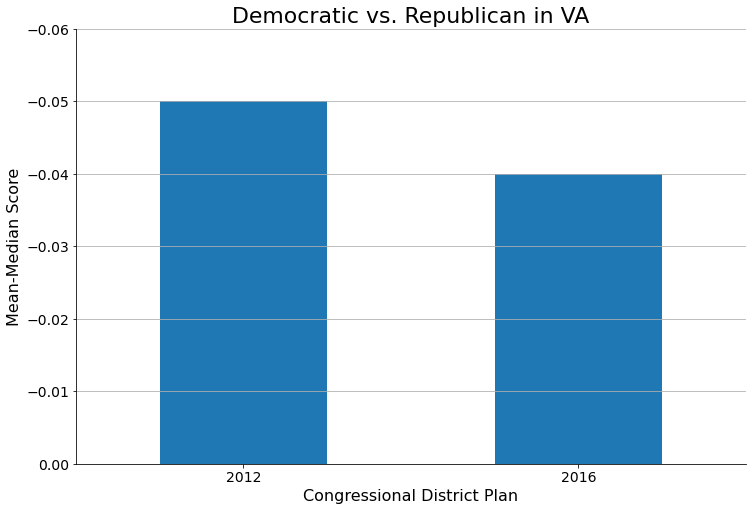

In [31]:
ylim = (0,-0.06)
title = "Democratic vs. Republican in VA"
xlab = 'Congressional District Plan'
ylab = 'Mean-Median Score'
plot_barchar(df_mm, title, xlab, ylab, ylim, legend=legend)

<a id='2.9'></a>
### 2.9 Partisan bias

Computes the partisan bias for the given ElectionResults. The partisan bias is defined as the number of districts with above-mean vote share by the first party divided by the total number of districts, minus 1/2.

In [32]:
metric = 'Partisan Bias'
plan2012 = pres16_12.partisan_bias
plan2016 = pres16_16.partisan_bias
df_pb = compute_metric(metric, plan2012, plan2016)
df_pb

,Partisan Bias
2012,-0.14
2016,-0.05


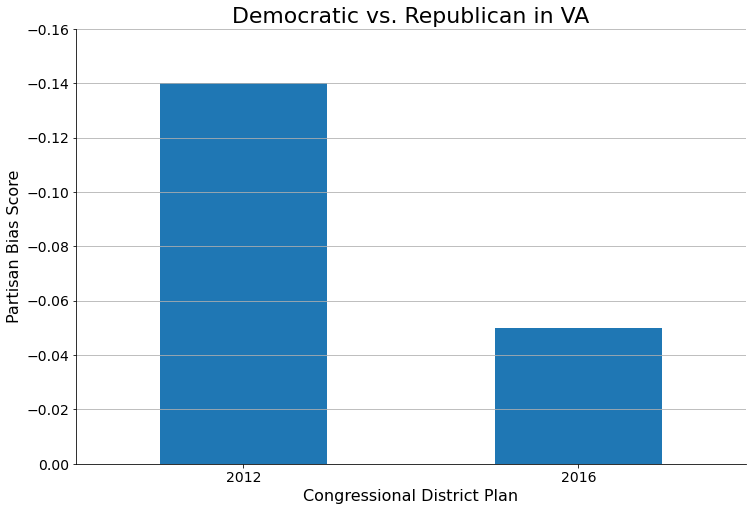

In [33]:
ylim = (0,-0.16)
title = "Democratic vs. Republican in VA"
xlab = 'Congressional District Plan'
ylab = 'Partisan Bias Score'
plot_barchar(df_pb, title, xlab, ylab, ylim, legend=legend)

<a id='2.10'></a>
### 2.10 Partisan gini

Computes the partisan Gini score for the given ElectionResults. The partisan Gini score is defined as the area between the seats-votes curve and its reflection about (.5, .5).

In [34]:
metric = 'Partisan Gini Index'
plan2012 = pres16_12.partisan_gini
plan2016 = pres16_16.partisan_gini
df_pg = compute_metric(metric, plan2012, plan2016)
df_pg

,Partisan Gini Index
2012,0.07
2016,0.03


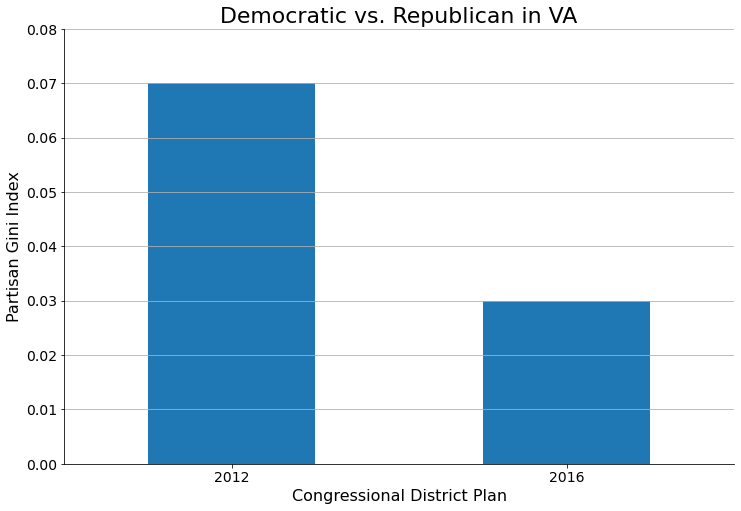

In [35]:
ylim = (0,0.08)
title = "Democratic vs. Republican in VA"
xlab = 'Congressional District Plan'
ylab = 'Partisan Gini Index'
plot_barchar(df_pg, title, xlab, ylab, ylim, legend=legend)